In [28]:
from riskeye.cogmodels.fit_probit import build_model, get_data
import arviz as az
from riskeye.cogmodels.utils import extract_intercept_gamma, get_rnp, format_bambi_ppc
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path as op
import pandas as pd
import numpy as np

target_dir = '/data/ds-riskeye/derivatives/figures'

In [29]:
def get_info(model_label, bids_folder='/data/ds-riskeye'):
    df = get_data(model_label, bids_folder=bids_folder)
    model = build_model(model_label, df)
    idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels/model-{model_label}_trace.netcdf'))

    intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
    rnp = get_rnp(intercept, gamma)

    # for x in [df, gamma, rnp]:
    #     x['Experiment'] = x.index.get_level_values('exptype').map({'symbolic':'Symbols', 'non-symbolic':'Coin clouds'})
    #     x.set_index('Experiment', append=True, inplace=True)

    return df, model, idata, gamma, rnp

In [30]:
# Probit00

In [4]:
model_label = 'probit00'
df, model, idata, gamma, rnp = get_info(model_label)

In [5]:
rnp.groupby('exptype').mean().mean(1)

exptype
non-symbolic    0.405386
symbolic        0.444336
dtype: float64

In [15]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.clip(get_rnp(intercept, gamma), 0, 1)
rnp = rnp.stack([1, 2])
gamma = gamma.stack([1, 2])

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [16]:
def get_hdi(d):
    return az.hdi(d.values)

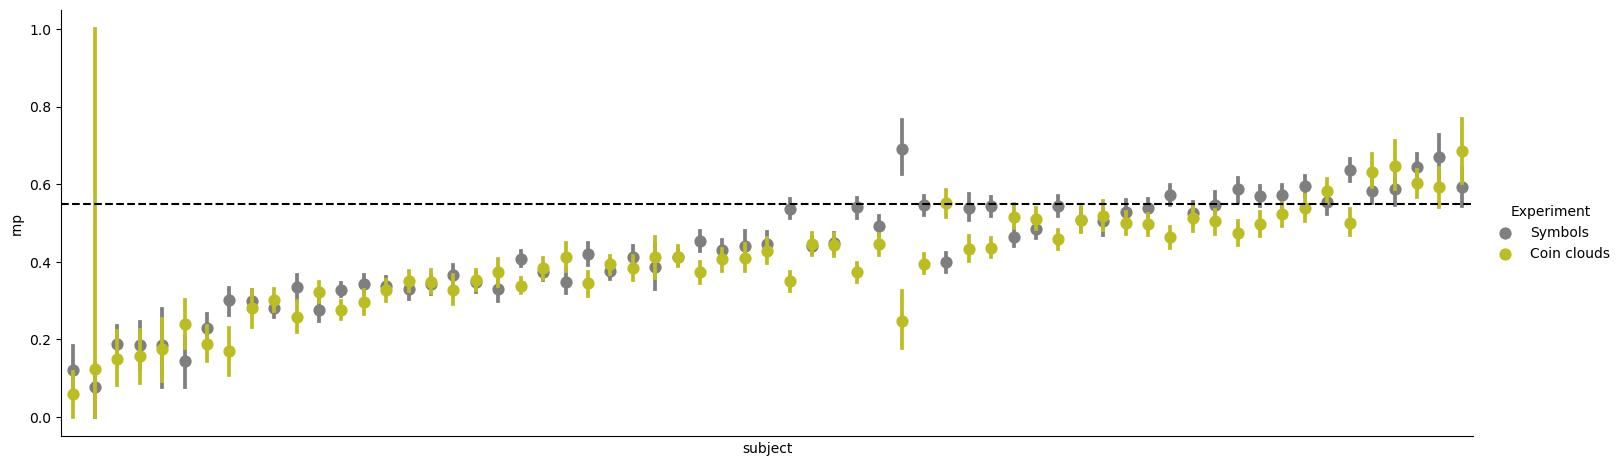

In [17]:
order = rnp.groupby('subject').mean().sort_values('rnp').index

g = sns.catplot(data=rnp.reset_index(), y='rnp', x='subject', order=order, kind='point', hue='Experiment', palette=sns.color_palette()[-3:], errorbar=get_hdi, aspect=3., join=False)

g.set(xticks=[])
plt.axhline(0.55, c='k', ls='--')

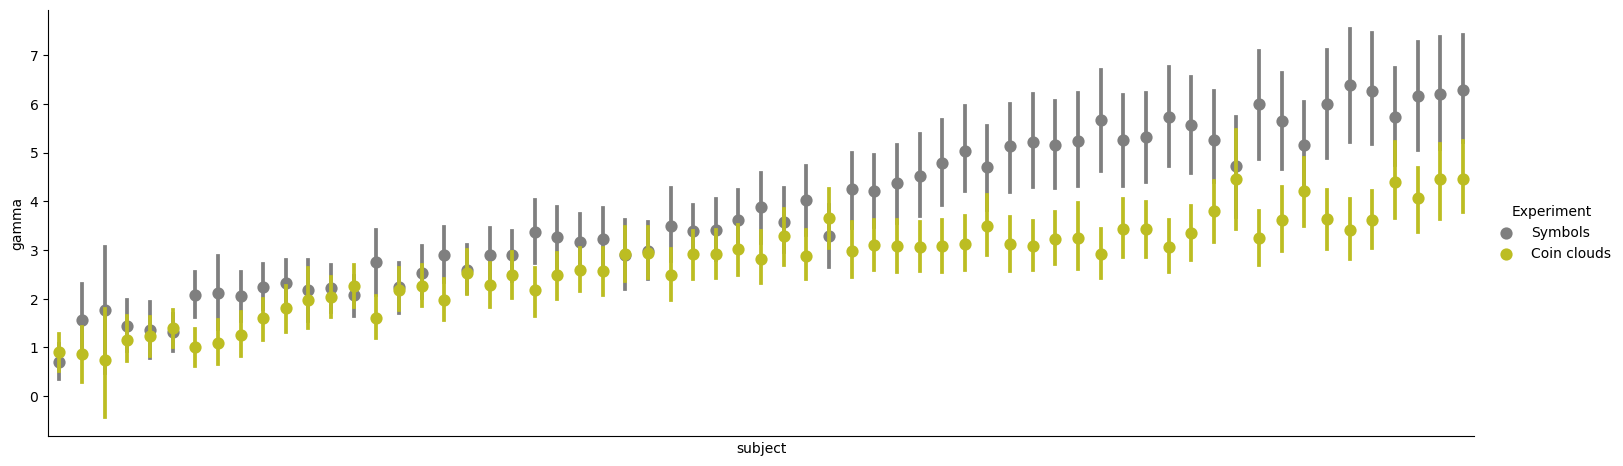

In [21]:
order = gamma.groupby('subject').mean().sort_values('gamma').index

g = sns.catplot(data=gamma.reset_index(), y='gamma', x='subject', order=order, kind='point', hue='Experiment', palette=sns.color_palette()[-3:], errorbar=get_hdi, aspect=3., join=False)

g.set(xticks=[])
# plt.axhline(0.55, c='k', ls='--')

In [22]:
subjectwise_gamma = gamma.groupby(['subject', 'exptype']).mean()

# Probit 0

In [24]:
model_label = 'probit0'
df, model, idata, gamma, rnp = get_info(model_label)

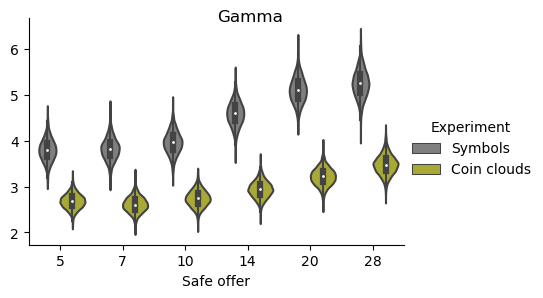

In [25]:
g = sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', hue='Experiment', kind='violin', palette=sns.color_palette()[-3:], height=3., aspect=1.5)
g.set(xlabel='Safe offer', ylabel=None)
g.fig.suptitle('Gamma')

g.savefig(op.join(target_dir, 'simple_probit_gamma.pdf'))

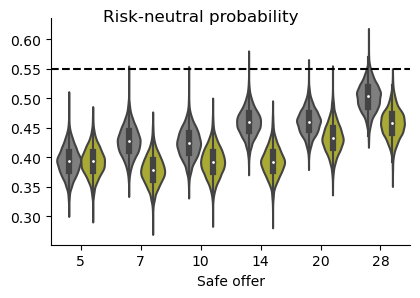

In [26]:
g = sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', hue='Experiment', kind='violin', palette=sns.color_palette()[-3:], height=3., legend=False, aspect=1.5)
plt.axhline(0.55, c='k', ls='--')
g.set(xlabel='Safe offer', ylabel=None)
g.fig.suptitle('Risk-neutral probability')

g.savefig(op.join(target_dir, 'simple_probit_rnp.pdf'))

In [61]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.clip(get_rnp(intercept, gamma), 0, 1)

rnp = rnp.stack([1, 2])

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [62]:
import statsmodels.api as sm

<Axes: xlabel='Experiment', ylabel='n_safe_slope'>

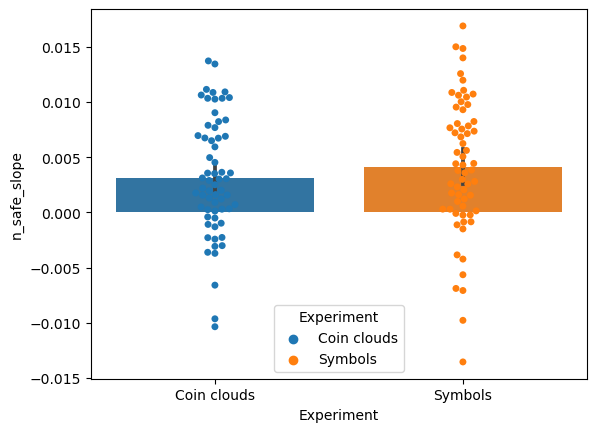

In [79]:
n_safe_slope = np.clip(rnp.groupby(['subject', 'Experiment']).apply(lambda d: sm.OLS(d['rnp'], sm.add_constant(d.index.get_level_values('n_safe'))).fit().params['x1']).to_frame('n_safe_slope'), -5, 5)


sns.barplot(x='Experiment', y='n_safe_slope', data=n_safe_slope.reset_index())
sns.swarmplot(x='Experiment', y='n_safe_slope', hue='Experiment', data=n_safe_slope.reset_index())

In [73]:
n_safe_slope['abs(n_safe_slope)'] = n_safe_slope['n_safe_slope'].abs()

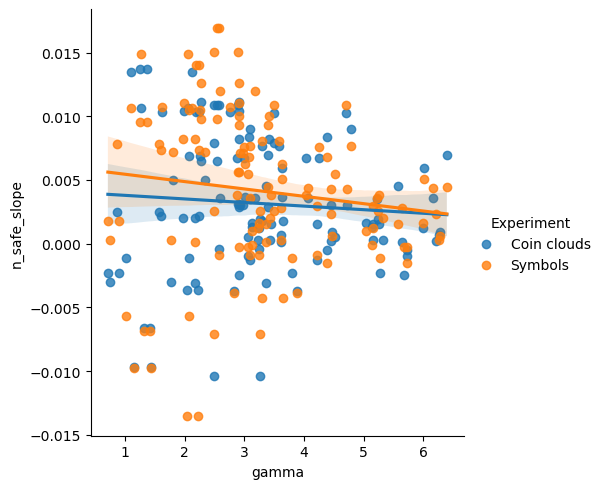

In [71]:
sns.lmplot(data=n_safe_slope.join(subjectwise_gamma).reset_index(), x='gamma', y='n_safe_slope', hue='Experiment')

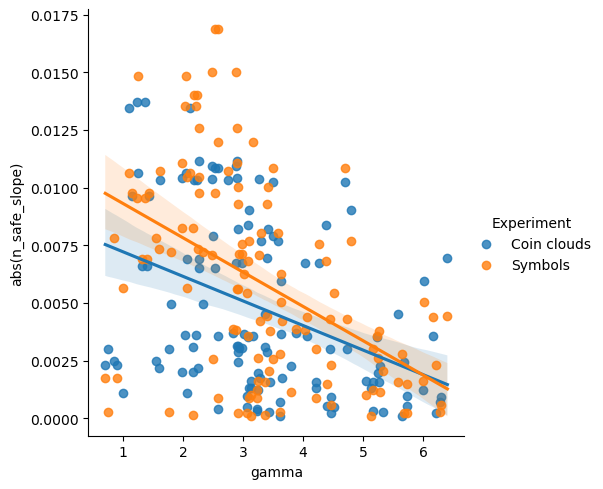

In [74]:
sns.lmplot(data=n_safe_slope.join(subjectwise_gamma).reset_index(), x='gamma', y='abs(n_safe_slope)', hue='Experiment')

In [83]:
nlc_idata = az.from_netcdf('/data/ds-riskeye/derivatives/cogmodels/model-1_trace.netcdf')

In [120]:
risky_prior_mu = nlc_idata.posterior['risky_prior_mu_mu'].to_dataframe().unstack(-1)
safe_prior_mu = nlc_idata.posterior['safe_prior_mu_mu'].to_dataframe().unstack(-1)

x = np.zeros((2,2))
x[0,0] = 1
x[1,:] = 1
x = pd.DataFrame(x, columns=risky_prior_mu.columns, index=pd.Index(['Coin clouds', 'Symbols'], name='Experiment'))
risky_prior_mu = risky_prior_mu.dot(x.T).stack().to_frame('risky_prior_mu')

x = np.zeros((2,2))
x[0,0] = 1
x[1,:] = 1
x = pd.DataFrame(x, columns=safe_prior_mu.columns, index=pd.Index(['Coin clouds', 'Symbols'], name='Experiment'))
safe_prior_mu = safe_prior_mu.dot(x.T).stack().to_frame('safe_prior_mu')

risky_prior_mu.join(safe_prior_mu).unstack('Experiment').corr()

risky_prior_mu           safe_prior_mu          
Experiment                    Coin clouds   Symbols   Coin clouds   Symbols
               Experiment                                                  
risky_prior_mu Coin clouds       1.000000  0.726657      0.299409  0.061239
               Symbols           0.726657  1.000000      0.115456  0.167581
safe_prior_mu  Coin clouds       0.299409  0.115456      1.000000  0.572133
               Symbols           0.061239  0.167581      0.572133  1.000000

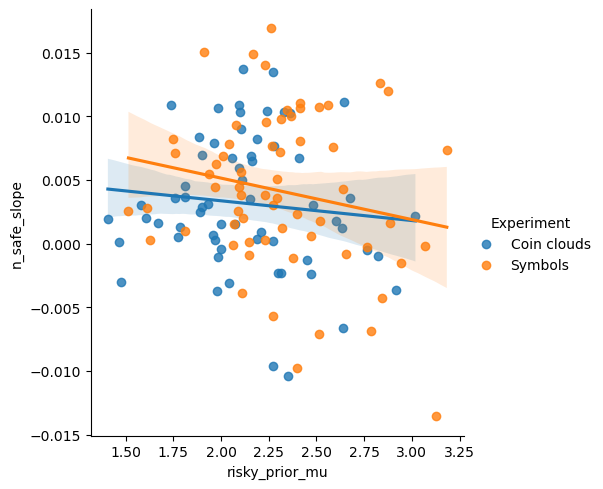

In [122]:
risky_prior_mu = nlc_idata.posterior['risky_prior_mu'].to_dataframe().unstack(-1)

x = np.zeros((2,2))
x[0,0] = 1
x[1,:] = 1
x = pd.DataFrame(x, columns=risky_prior_mu.columns, index=pd.Index(['Coin clouds', 'Symbols'], name='Experiment'))

risky_prior_mu = risky_prior_mu.dot(x.T).stack().to_frame('risky_prior_mu').groupby(['subject', 'Experiment']).mean()

sns.lmplot(data=risky_prior_mu.join(n_safe_slope).reset_index(), x='risky_prior_mu', y='n_safe_slope', hue='Experiment')

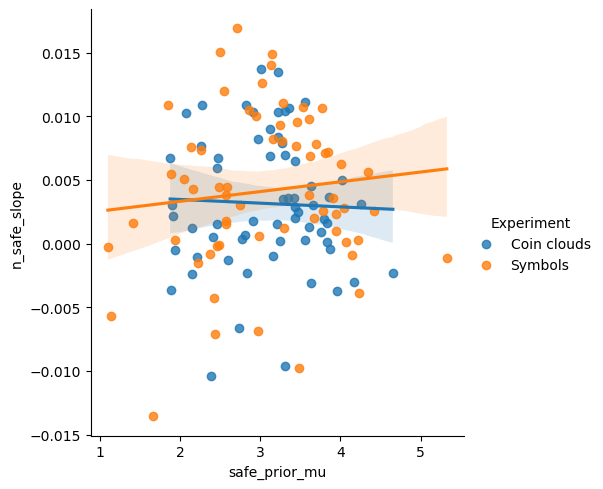

In [123]:
safe_prior_mu = nlc_idata.posterior['safe_prior_mu'].to_dataframe().unstack(-1)

x = np.zeros((2,2))
x[0,0] = 1
x[1,:] = 1
x = pd.DataFrame(x, columns=safe_prior_mu.columns, index=pd.Index(['Coin clouds', 'Symbols'], name='Experiment'))

safe_prior_mu = safe_prior_mu.dot(x.T).stack().to_frame('safe_prior_mu').groupby(['subject', 'Experiment']).mean()

sns.lmplot(data=safe_prior_mu.join(n_safe_slope).reset_index(), x='safe_prior_mu', y='n_safe_slope', hue='Experiment')

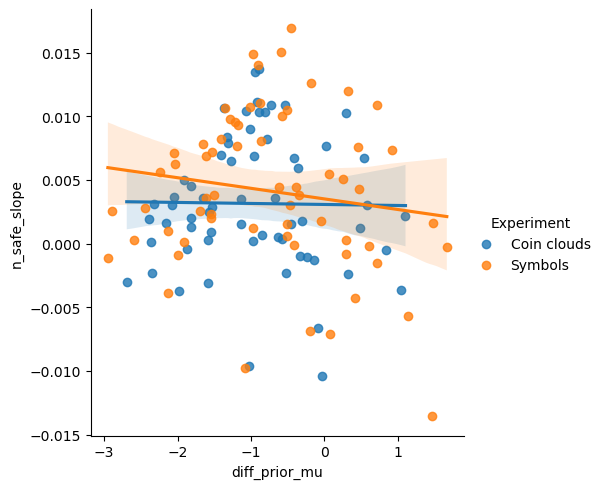

In [133]:
diff_prior_mu = (risky_prior_mu['risky_prior_mu'] - safe_prior_mu['safe_prior_mu']).to_frame('diff_prior_mu')

sns.lmplot(data=diff_prior_mu.join(n_safe_slope).reset_index(), x='diff_prior_mu', y='n_safe_slope', hue='Experiment')

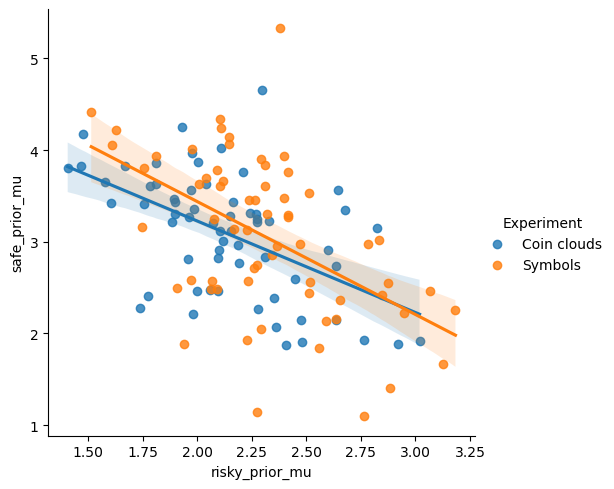

In [128]:
sns.lmplot(data=risky_prior_mu.join(safe_prior_mu).reset_index(), x='risky_prior_mu', y='safe_prior_mu', hue='Experiment')

In [ ]:
sm.add_constant(d['n_safe'])

In [10]:
ppc = format_bambi_ppc(idata.sel(draw=slice(None, None, 20)), model, df)

In [11]:
from riskeye.cogmodels.utils import plot_ppc

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


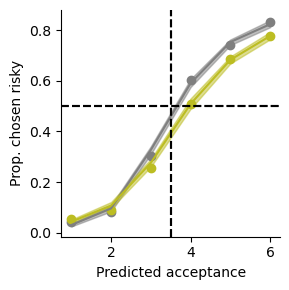

In [16]:
plot_ppc(df, ppc, plot_type=0, level='group', legend=False)

plt.savefig(op.join(target_dir, f'probit_simple_ppc1.pdf'), dpi=300)

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


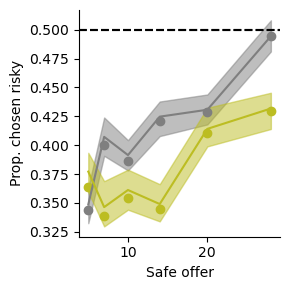

In [17]:
g = plot_ppc(df, ppc, level='group', plot_type=1, legend=False)
# g.set(xticks=[], xlabel='Choice bin')

plt.savefig(op.join(target_dir, f'probit_simple_ppc2.pdf'), dpi=300)

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


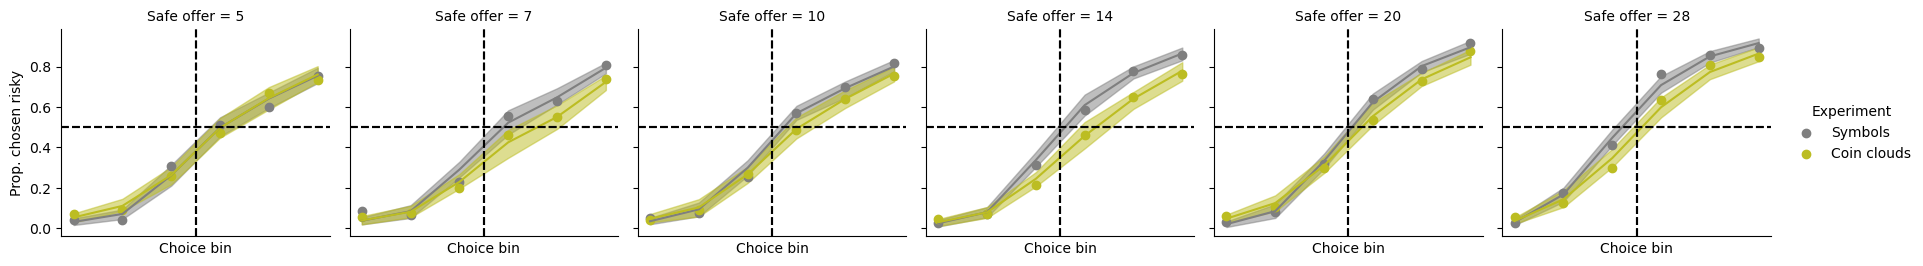

In [ ]:
g = plot_ppc(df, ppc, level='group', plot_type=2)
g.set(xticks=[], xlabel='Choice bin')

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


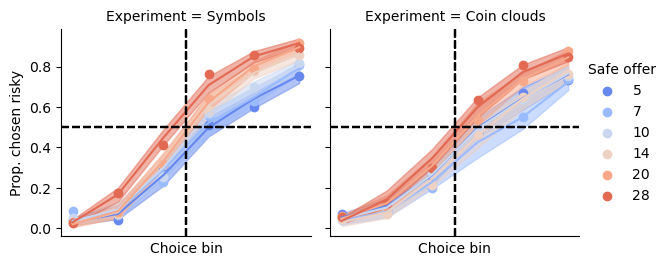

In [ ]:
g = plot_ppc(df, ppc, level='group', plot_type=3)
g.set(xticks=[], xlabel='Choice bin')

# Probit 0b

In [11]:
model_label = 'probit0b'
df, model, idata, gamma, rnp = get_info(model_label)

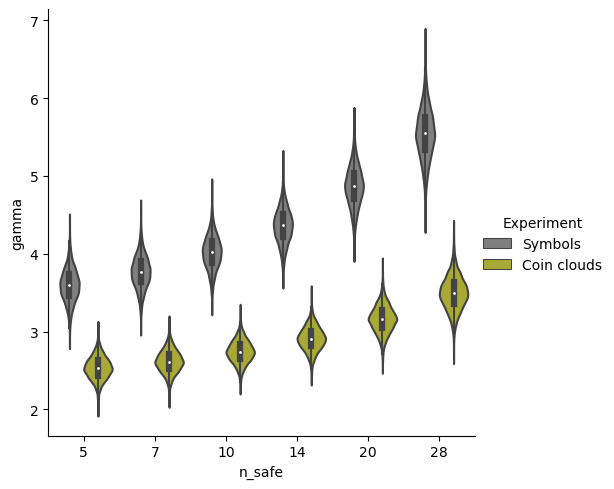

In [12]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', hue='Experiment', kind='violin', palette=sns.color_palette()[-3:])

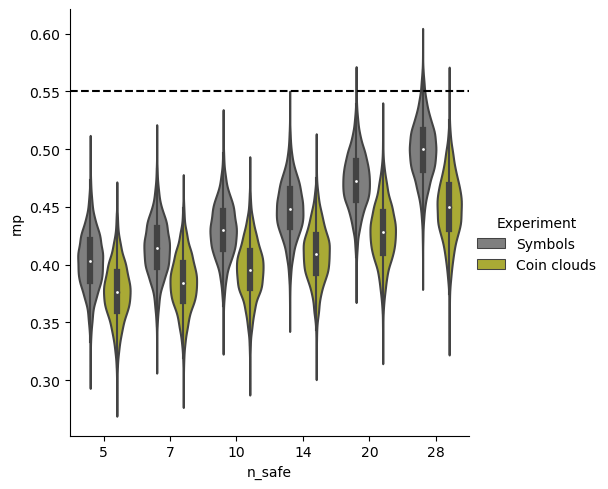

In [13]:
sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', hue='Experiment', kind='violin', palette=sns.color_palette()[-3:])
plt.axhline(0.55, c='k', ls='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_59610/2075748493.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['n_safe'])
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_59610/2075748493.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posteri

<Axes: xlabel='exptype:n_safe', ylabel='Density'>

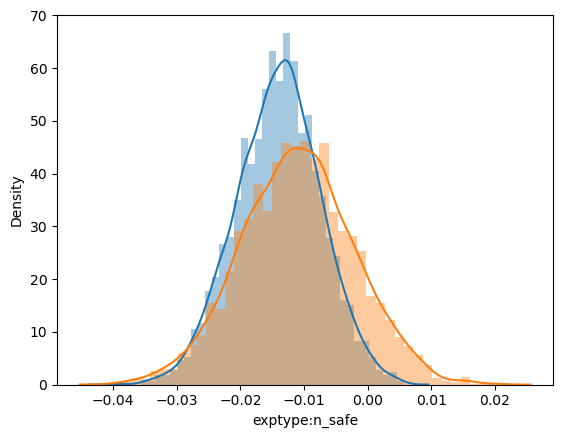

In [32]:
sns.distplot(idata.posterior['n_safe'])
sns.distplot(idata.posterior['exptype:n_safe'])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_59610/1486076940.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['x:n_safe'])
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_59610/1486076940.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.poste

<Axes: xlabel='x:exptype:n_safe', ylabel='Density'>

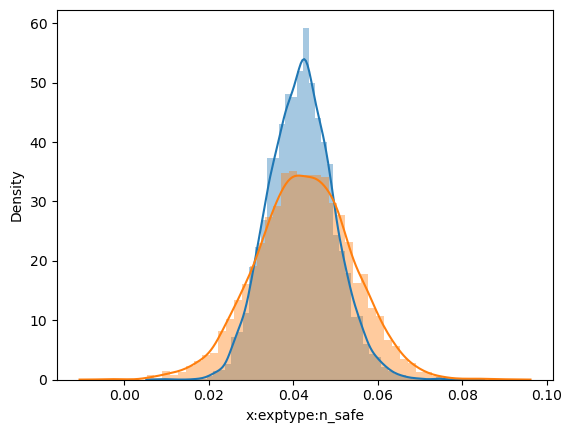

In [25]:
sns.distplot(idata.posterior['x:n_safe'])
sns.distplot(idata.posterior['x:exptype:n_safe'])

In [28]:
ppc = format_bambi_ppc(idata.sel(draw=slice(None, None, 20)), model, df)

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


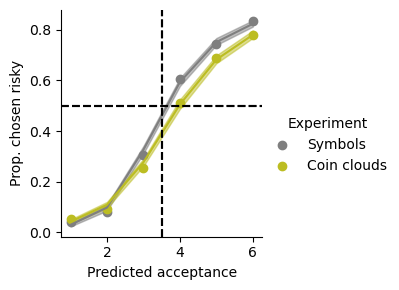

In [29]:
plot_ppc(df, ppc, plot_type=0, level='group')

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


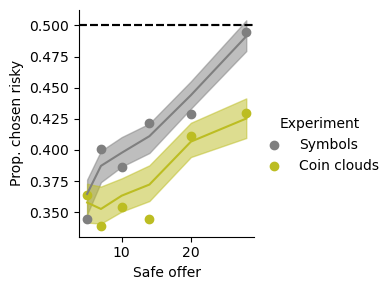

In [30]:
g = plot_ppc(df, ppc, level='group', plot_type=1)
# g.set(xticks=[], xlabel='Choice bin')

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


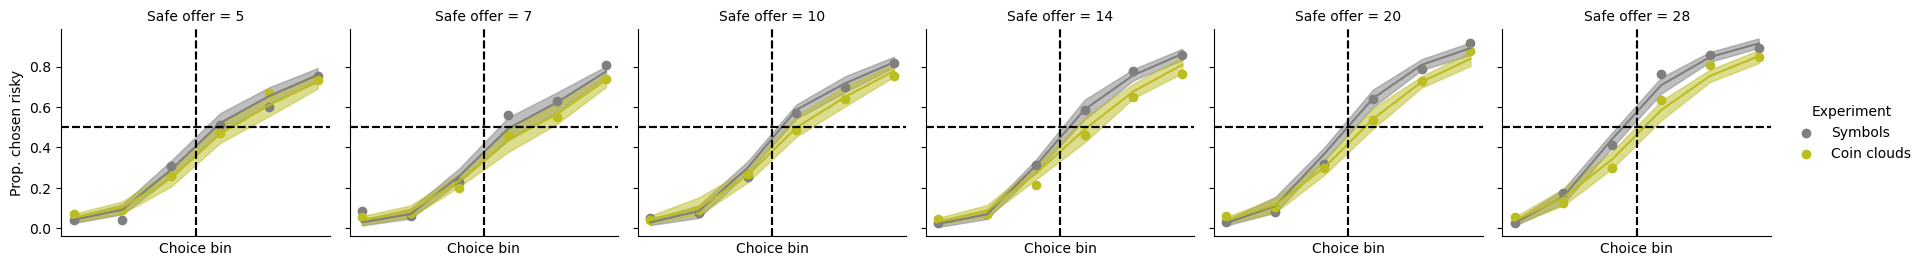

In [31]:
g = plot_ppc(df, ppc, level='group', plot_type=2)
g.set(xticks=[], xlabel='Choice bin')

# Probit 1

In [39]:
model_label = 'probit1'
df, model, idata, gamma, rnp = get_info(model_label)

FileNotFoundError: [Errno 2] No such file or directory: b'/data/ds-riskeye/derivatives/cogmodels/model-probit1_trace.netcdf'

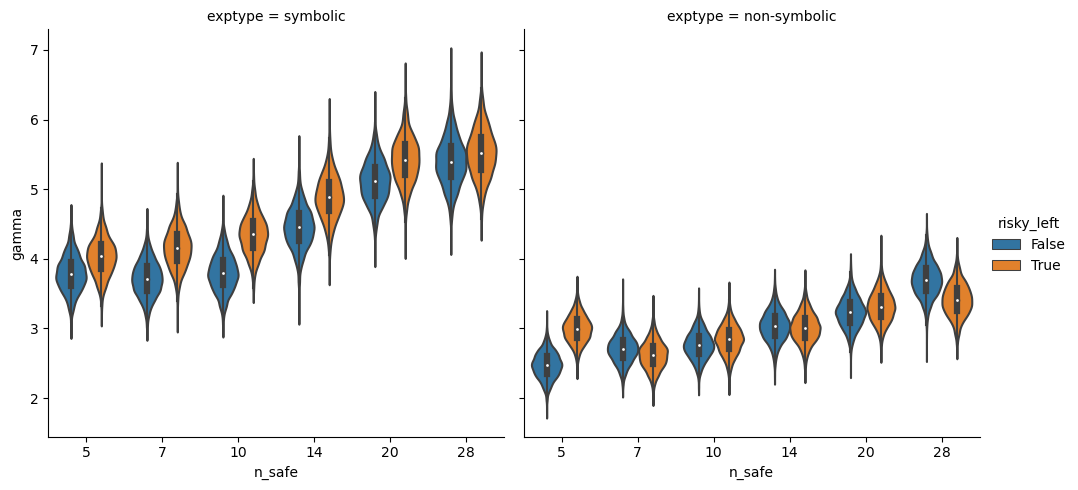

In [ ]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', hue='risky_left', col='exptype', kind='violin')

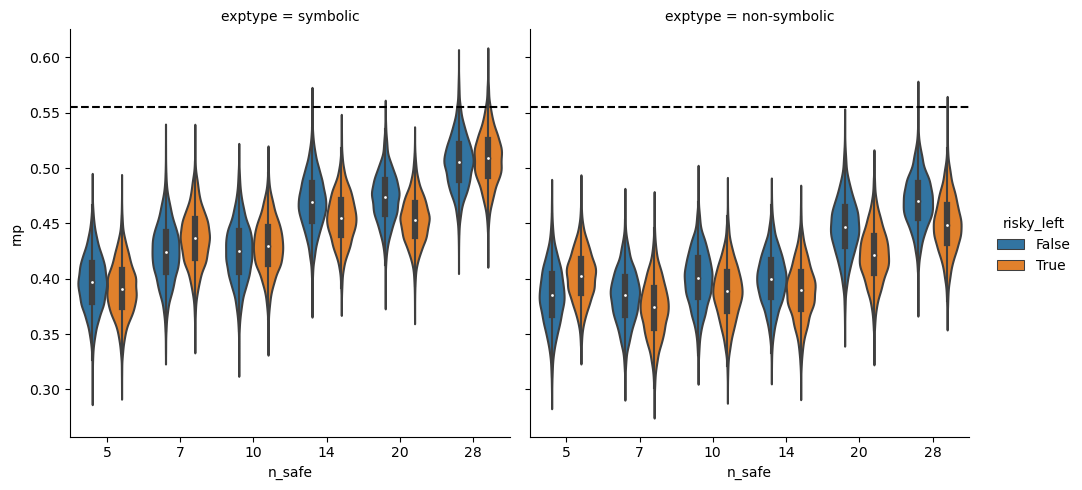

In [ ]:
g = sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', hue='risky_left', col='exptype', kind='violin')
g.map(lambda *args, **kwargs: plt.axhline(0.5555555, color='k', linestyle='--'))

diff
exptype      n_safe         
non-symbolic 5       0.00200
             7       0.66600
             10      0.33850
             14      0.56025
             20      0.33275
             28      0.90700
symbolic     5       0.15875
             7       0.03300
             10      0.01050
             14      0.06050
             20      0.14825
             28      0.34400

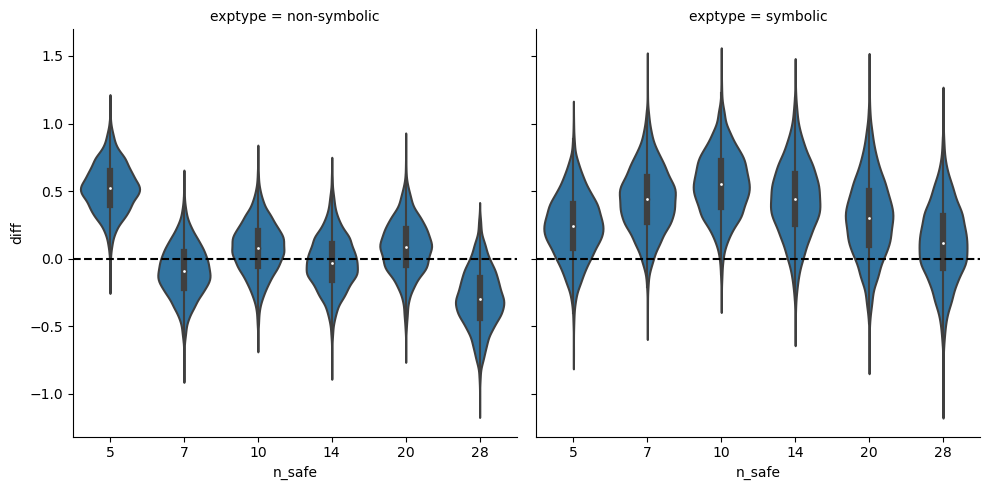

In [ ]:
tmp = gamma.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs(True, 0, level='risky_left') - tmp.xs(False, 0, level='risky_left')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

diff
exptype      n_safe         
non-symbolic 5       0.07775
             7       0.79925
             10      0.84325
             14      0.82750
             20      0.98775
             28      0.95950
symbolic     5       0.72075
             7       0.15875
             10      0.29450
             14      0.89950
             20      0.98225
             28      0.38025

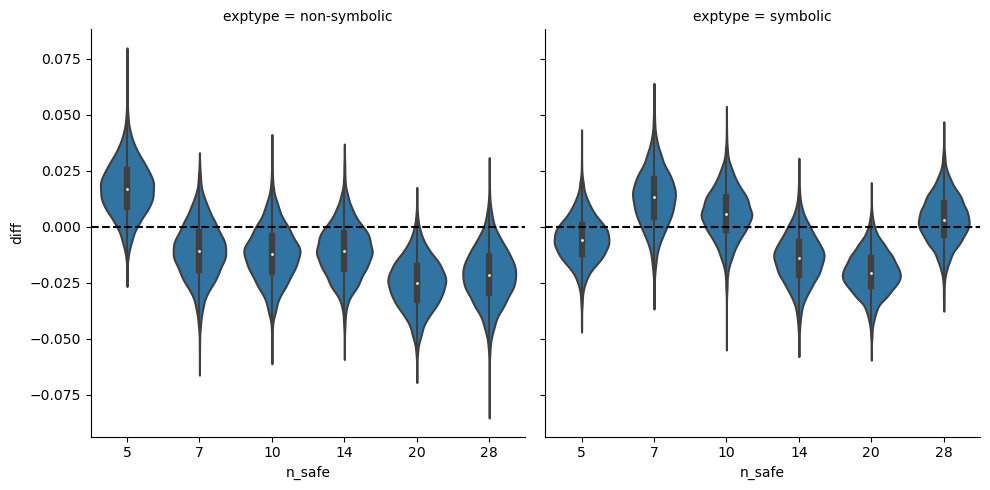

In [ ]:
tmp = rnp.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs(True, 0, level='risky_left') - tmp.xs(False, 0, level='risky_left')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

# Probit 2

In [ ]:
model_label = 'probit2'
df, model, idata, gamma, rnp = get_info(model_label)

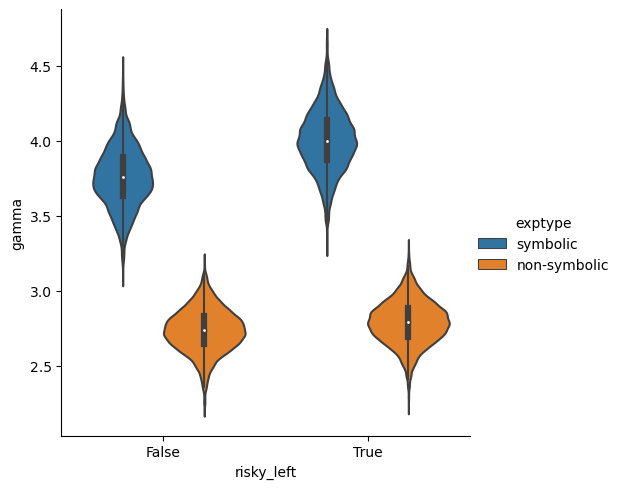

In [ ]:
import seaborn as sns
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='risky_left', y='gamma', hue='exptype', kind='violin')

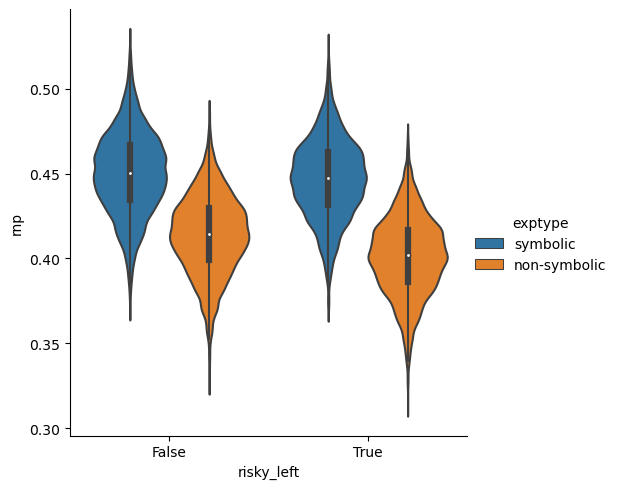

In [ ]:
import seaborn as sns
sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='risky_left', y='rnp', hue='exptype', kind='violin')

,diff
exptype,
non-symbolic,0.97450
symbolic,0.72075


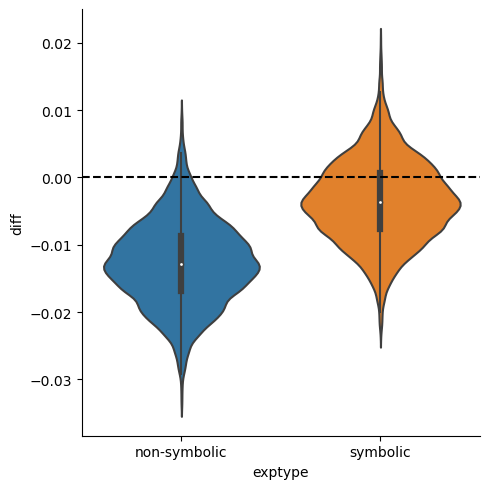

In [ ]:
tmp = rnp.stack([1,2]).unstack(['risky_left']).droplevel(0, 1)
diff = (tmp[True] - tmp[False]).to_frame('diff')
sns.catplot(x='exptype', y='diff', data=diff.reset_index(), kind='violin')
plt.axhline(0.0, c='k', ls='--')

diff.groupby(['exptype']).apply(lambda x: (x<0.0).mean())

# probit_risky_looked_at_first_simple

In [40]:
model_label = 'probit_risky_looked_at_first_simple'
df, model, idata, gamma, rnp = get_info(model_label)

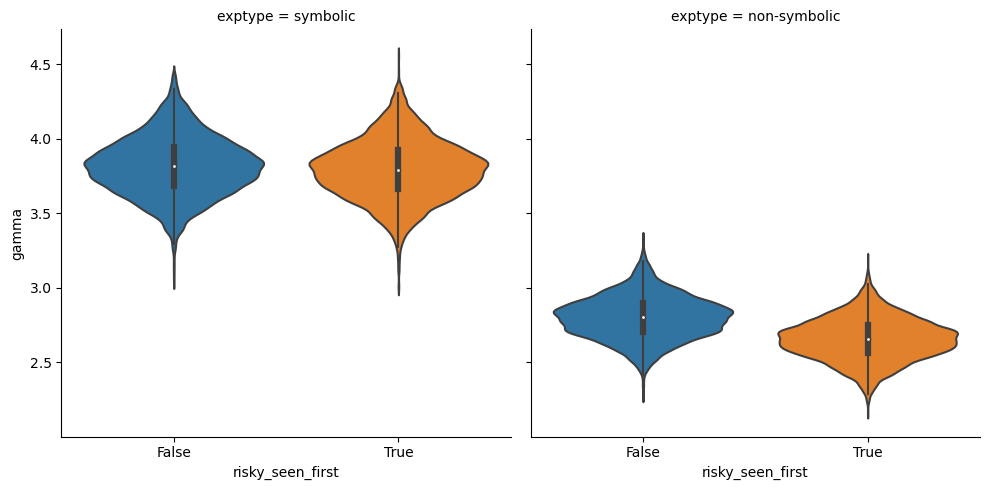

In [41]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), y='gamma', x='risky_seen_first', col='exptype', kind='violin')

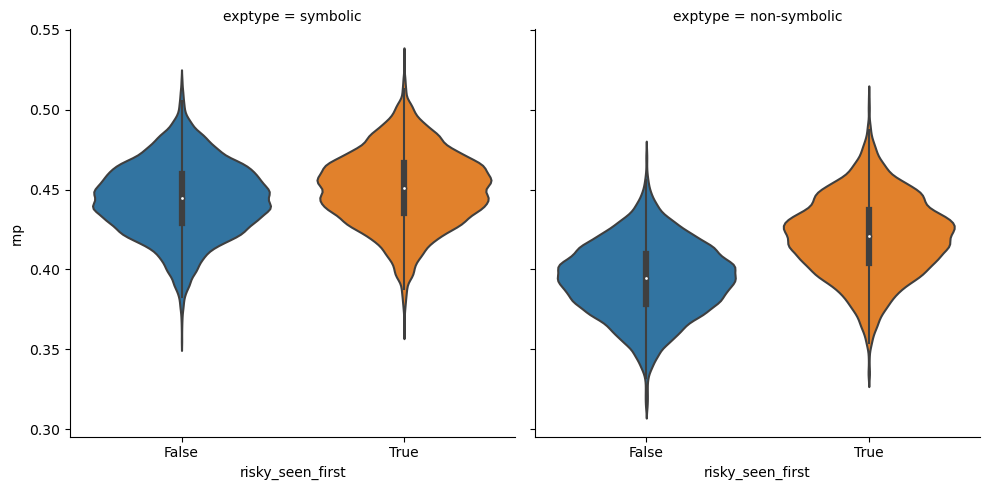

In [42]:
sns.catplot(data=rnp.stack([1, 2]).reset_index(), y='rnp', x='risky_seen_first', col='exptype', kind='violin')

,diff
exptype,
non-symbolic,0.0000
symbolic,0.1035


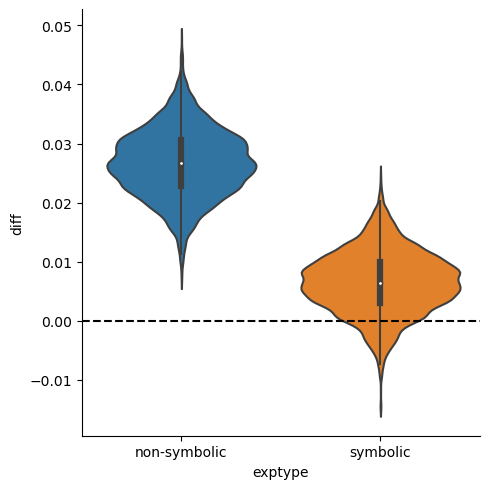

In [43]:
tmp = rnp.stack([1,2]).unstack(['risky_seen_first']).droplevel(0, 1)
diff = (tmp[True] - tmp[False]).to_frame('diff')
sns.catplot(x='exptype', y='diff', data=diff.reset_index(), kind='violin')
plt.axhline(0.0, c='k', ls='--')

diff.groupby(['exptype']).apply(lambda x: (x<0.0).mean())

# Probit first looked at

In [3]:
model_label = 'probit_risky_looked_at_first'
df, model, idata, gamma, rnp = get_info(model_label)

In [39]:
df['saw_risky_last'] = ((df['last_saccade'] == 'left_option') & (df['p_left']==0.55)) | ((df['last_saccade'] == 'right_option') & (df['p_right']==.55))
df['Last fixation'] = df['saw_risky_last'].map({True:'Risky', False:'Safe'})

In [40]:
gamma

gamma            \
chain                                                           0             
draw                                                          0         1     
subject n_safe exptype      risky_seen_last Experiment                        
1       14     symbolic     True            Symbols      4.910771  5.018500   
                            False           Symbols      4.293932  4.266207   
               non-symbolic True            Coin clouds  3.075629  3.293563   
                            False           Coin clouds  2.681025  2.889032   
        5      symbolic     True            Symbols      3.791929  3.684057   
                            False           Symbols      4.506101  4.396375   
               non-symbolic True            Coin clouds  2.734510  2.619214   
                            False           Coin clouds  2.805062  2.670746   
        10     symbolic     True            Symbols      4.004234  4.305967   
                            False           Symbols      3.543022  3.676749   
               non-symbolic True            Coin clouds  2.635122  2.705554   
                            False           Coin clouds  3.297853  2.736516   
        28     symbolic     True            Symbols      5.136634  5.193459   
                            False           Symbols      5.745881  5.633895   
               non-symbolic True            Coin clouds  4.072506  3.411943   
                            False           Coin clouds  3.855173  3.542124   
        20     symbolic     True            Symbols      6.011567  5.831957   
                            False           Symbols      4.016191  4.232994   
               non-symbolic True            Coin clouds  3.330282  3.451684   
                            False           Coin clouds  3.022242  3.008729   
        7      symbolic     True            Symbols      3.656103  4.021493   
                            False           Symbols      3.570930  3.650563   
               non-symbolic True            Coin clouds  2.819256  2.792242   
                            False           Coin clouds  2.622670  2.784783   

                                                                             \
chain                                                                         
draw                                                          2         3     
subject n_safe exptype      risky_seen_last Experiment                        
1       14     symbolic     True            Symbols      4.629568  4.814410   
                            False           Symbols      4.472629  4.467403   
               non-symbolic True            Coin clouds  3.143254  2.936796   
                            False           Coin clouds  2.838569  2.797743   
        5      symbolic     True            Symbols      3.907672  3.584426   
                            False           Symbols      4.259775  3.812134   
               non-symbolic True            Coin clouds  2.819643  2.557196   
                            False           Coin clouds  2.917095  2.517152   
        10     symbolic     True            Symbols      4.510151  4.046182   
                            False           Symbols      3.925296  3.394237   
               non-symbolic True            Coin clouds  2.646840  2.435210   
                            False           Coin clouds  3.019494  2.719460   
        28     symbolic     True            Symbols      5.172254  5.164980   
                            False           Symbols      5.800822  5.915643   
               non-symbolic True            Coin clouds  3.834993  3.569246   
                            False           Coin clouds  3.729815  3.399771   
        20     symbolic     True            Symbols      5.858985  6.764373   
                            False           Symbols      4.734550  4.564122   
               non-symbolic True            Coin clouds  3.417602  3.050517   
                            Fa

In [41]:
gamma = gamma.set_index(pd.Series(gamma.index.get_level_values('risky_seen_last').to_series().map({True:'Risky', False:'Safe'}), name='Last fixation'), append=True)
rnp = rnp.set_index(pd.Series(rnp.index.get_level_values('risky_seen_last').to_series().map({True:'Risky', False:'Safe'}), name='Last fixation'), append=True)

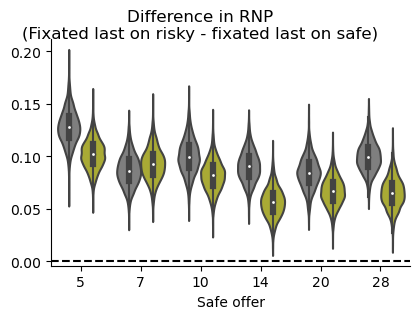

In [42]:
tmp = rnp.droplevel('exptype').droplevel('risky_seen_last').stack([1, 2]).unstack(['Experiment', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs('Risky', 0, level='Last fixation') - tmp.xs('Safe', 0, level='Last fixation')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', hue='Experiment', data=tmp.reset_index(), kind='violin', palette=sns.color_palette()[-3:], aspect=1.5, height=3., legend=False)
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))

g.set(xlabel='Safe offer', ylabel=None)
g.fig.suptitle('Difference in RNP\n(Fixated last on risky - fixated last on safe)', y=1.05)
tmp.groupby(['Experiment', 'n_safe']).apply(lambda x: (x<0.0).mean())


g.savefig(op.join(target_dir, 'probit_last_fixation_rnp_diff.pdf'), bbox_inches='tight')

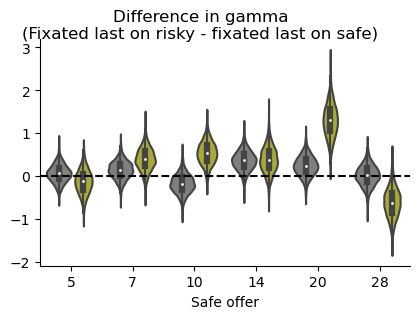

In [43]:
tmp = gamma.droplevel('exptype').droplevel('risky_seen_last').stack([1, 2]).unstack(['Experiment', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs('Risky', 0, level='Last fixation') - tmp.xs('Safe', 0, level='Last fixation')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', hue='Experiment', data=tmp.reset_index(), kind='violin', palette=sns.color_palette()[-3:], aspect=1.5, height=3., legend=False)
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))

g.set(xlabel='Safe offer', ylabel=None)
g.fig.suptitle('Difference in gamma\n(Fixated last on risky - fixated last on safe)', y=1.05)
tmp.groupby(['Experiment', 'n_safe']).apply(lambda x: (x<0.0).mean())


g.savefig(op.join(target_dir, 'probit_last_fixation_gamma_diff.pdf'), bbox_inches='tight')

# Probit last looked at (simple)

In [49]:
model_label = 'probit_risky_looked_at_last_simple'
df, model, idata, gamma, rnp = get_info(model_label)

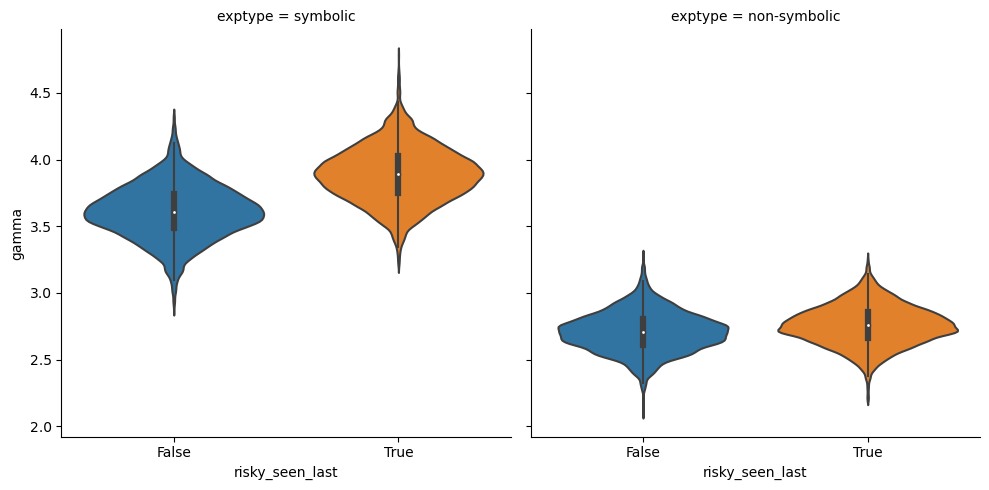

In [50]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), y='gamma', x='risky_seen_last', col='exptype', kind='violin')

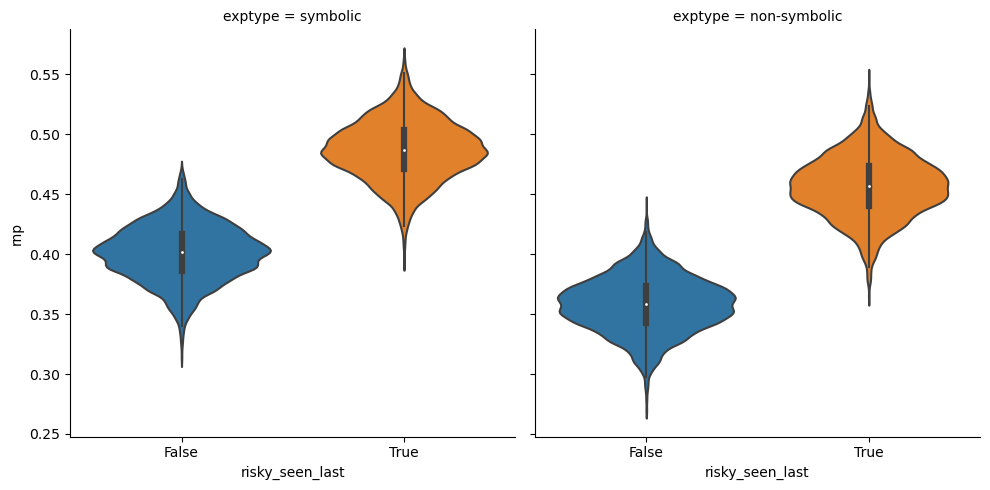

In [51]:
sns.catplot(data=rnp.stack([1, 2]).reset_index(), y='rnp', x='risky_seen_last', col='exptype', kind='violin')

# Probit last looked at

In [1]:
model_label = 'probit_risky_looked_at_last'
df, model, idata, gamma, rnp = get_info(model_label)

NameError: name 'get_info' is not defined

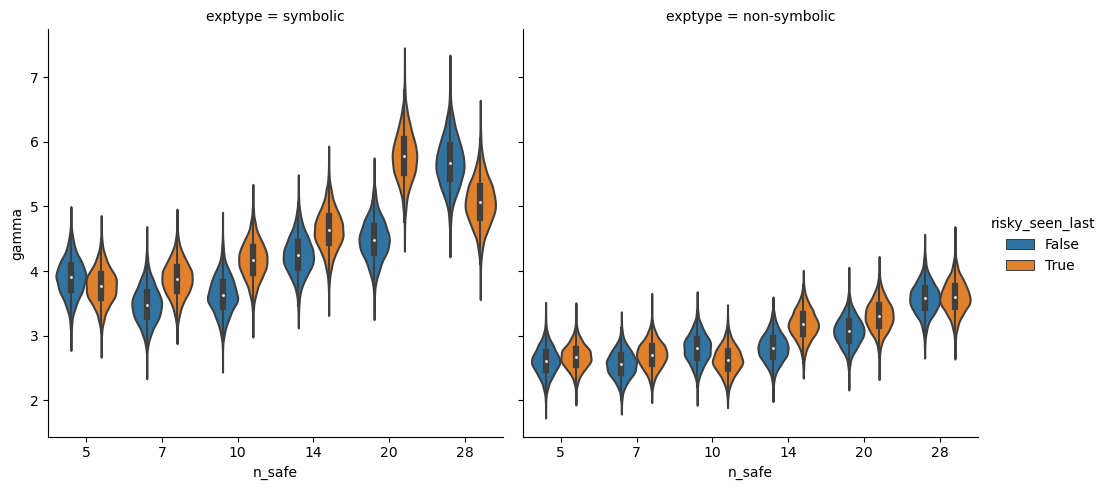

In [53]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', hue='risky_seen_last', col='exptype', kind='violin')

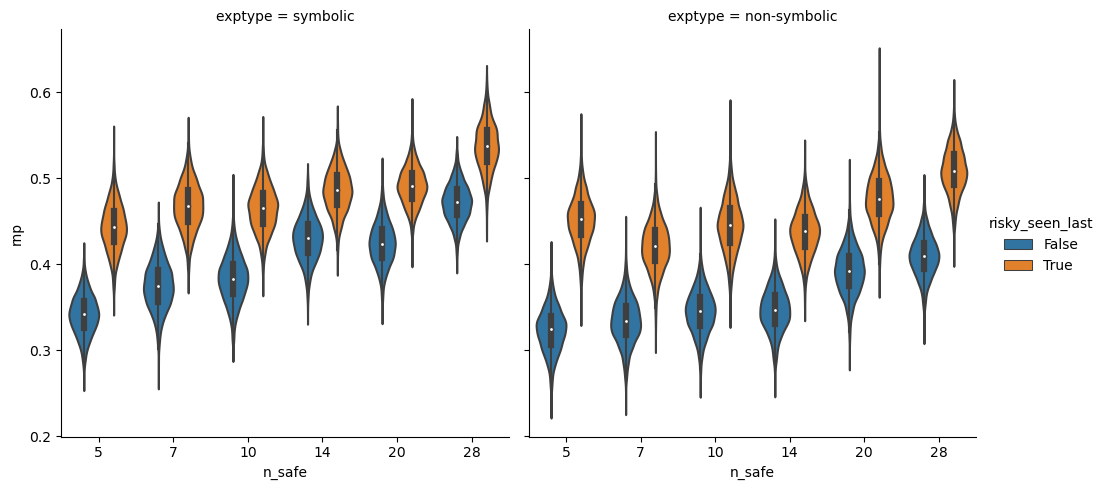

In [54]:
sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', hue='risky_seen_last', col='exptype', kind='violin')

diff
exptype      n_safe      
non-symbolic 5        0.0
             7        0.0
             10       0.0
             14       0.0
             20       0.0
             28       0.0
symbolic     5        0.0
             7        0.0
             10       0.0
             14       0.0
             20       0.0
             28       0.0

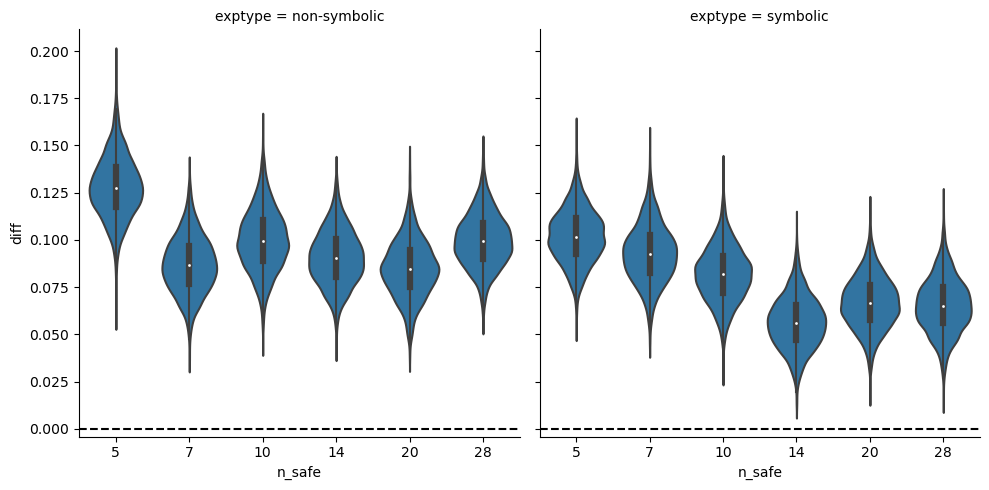

In [55]:
tmp = rnp.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs(True, 0, level='risky_seen_last') - tmp.xs(False, 0, level='risky_seen_last')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

# Probit proportion looked at risky option

In [5]:
model_label = 'probit_prop_looked_at_risky'
df, model, idata, gamma, rnp = get_info(model_label)

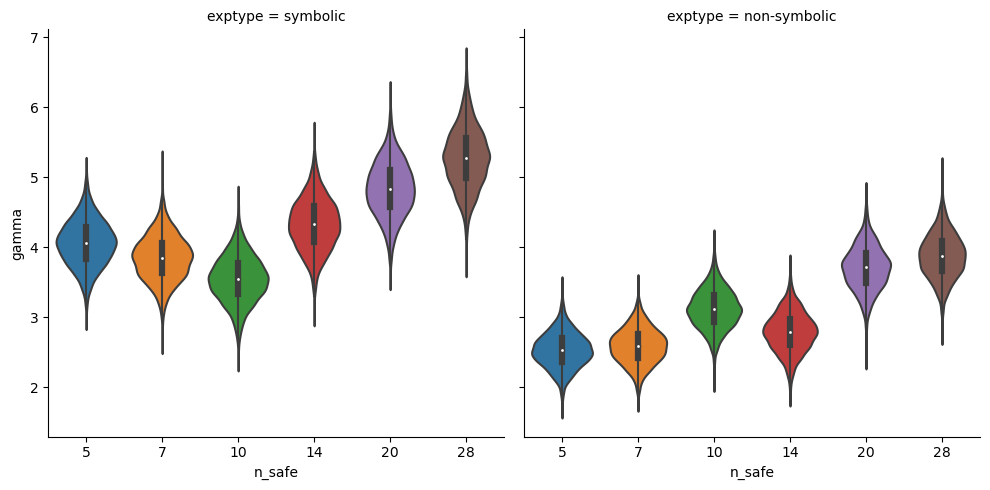

In [7]:
sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', col='exptype', kind='violin')

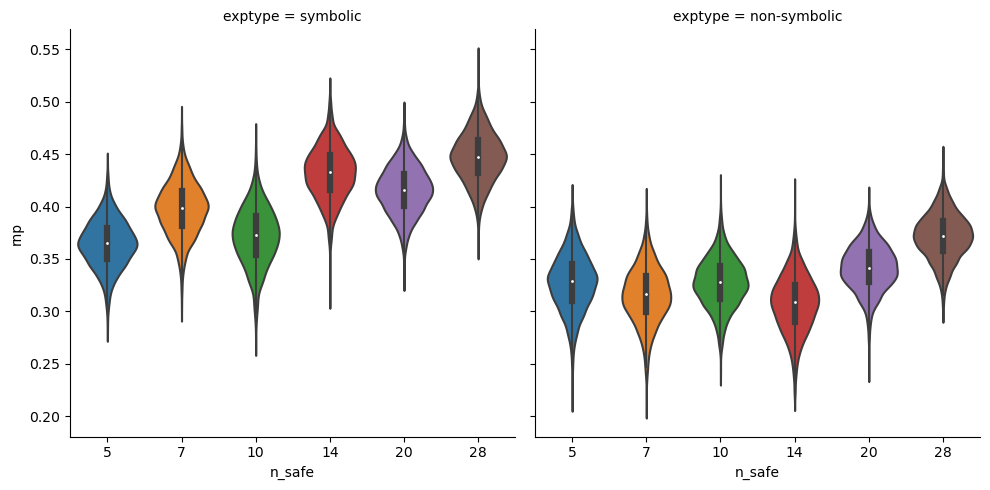

In [8]:
sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', col='exptype', kind='violin')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27799/3737707792.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['x:risky_duration_prop'].to_dataframe())


<Axes: ylabel='Density'>

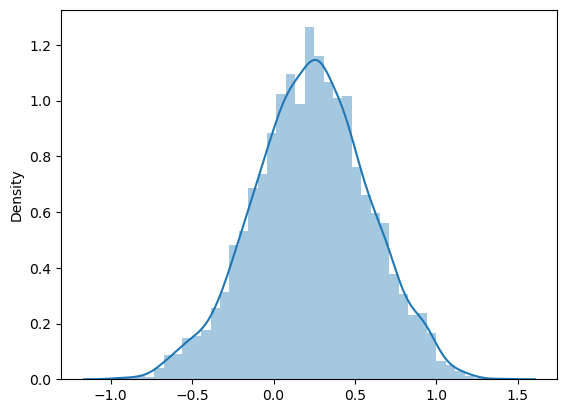

In [13]:
sns.distplot(idata.posterior['x:risky_duration_prop'].to_dataframe())

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27799/2740964893.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['x:risky_duration_prop'].to_dataframe())
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27799/2740964893.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

<Axes: ylabel='Density'>

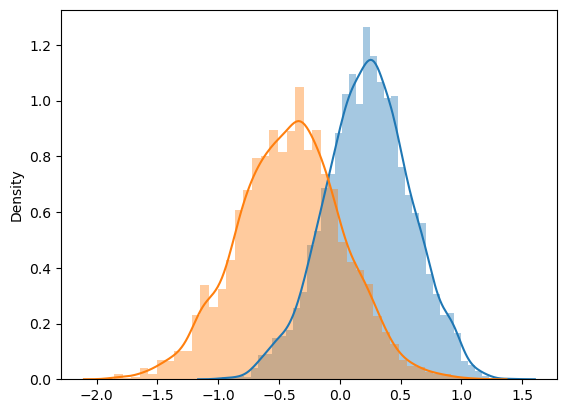

In [22]:
sns.distplot(idata.posterior['x:risky_duration_prop'].to_dataframe())
sns.distplot(idata.posterior['x:risky_duration_prop'].to_dataframe() + idata.posterior['x:risky_duration_prop:exptype'].to_dataframe().values)

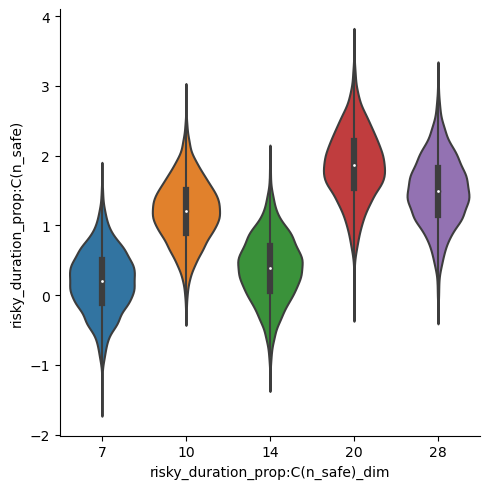

In [27]:
sns.catplot(x='risky_duration_prop:C(n_safe)_dim', y='risky_duration_prop:C(n_safe)', data=idata.posterior['risky_duration_prop:C(n_safe)'].to_dataframe().reset_index(), kind='violin')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27799/1158704521.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['risky_duration_prop:C(n_safe)'].to_dataframe())


<Axes: ylabel='Density'>

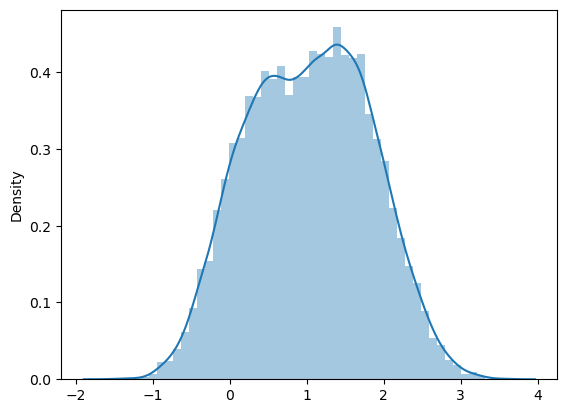

In [24]:
sns.distplot(idata.posterior['risky_duration_prop:C(n_safe)'].to_dataframe())

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27799/3025811428.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['risky_duration_prop'].to_dataframe())
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27799/3025811428.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: ylabel='Density'>

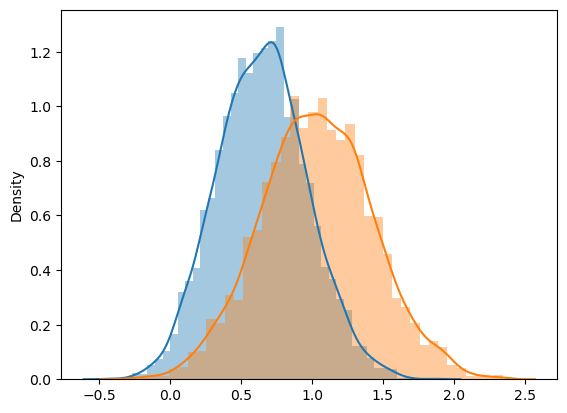

In [21]:
sns.distplot(idata.posterior['risky_duration_prop'].to_dataframe())
sns.distplot(idata.posterior['risky_duration_prop'].to_dataframe() + idata.posterior['risky_duration_prop:exptype'].to_dataframe().values)

# Probit proportion looked at risky option (median split) - SIMPLE

In [3]:
model_label = 'probit_prop_looked_at_risky_mediansplit_simple'
df, model, idata, gamma, rnp = get_info(model_label)

rnp.set_index(pd.Index(rnp.index.get_level_values('risky_duration_prop_split').to_series().map({'high':'Long', 'low':'Short'}), name='Risky dwell time'), append=True, inplace=True)
gamma.set_index(pd.Index(gamma.index.get_level_values('risky_duration_prop_split').to_series().map({'high':'Long', 'low':'Short'}), name='Risky dwell time'), append=True, inplace=True)

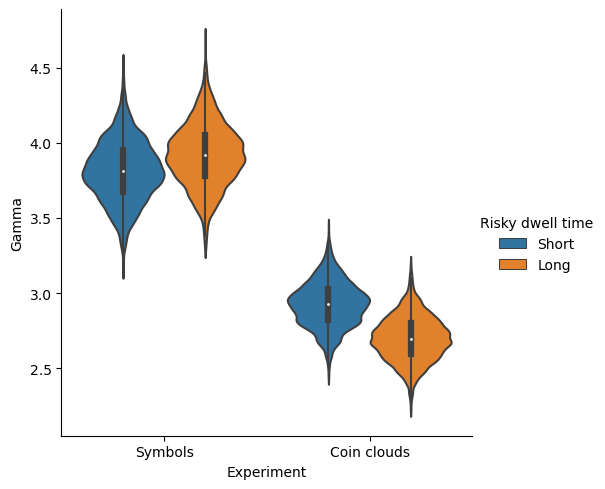

In [6]:
g = sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='Experiment', y='gamma', kind='violin', hue='Risky dwell time', col_order=['Coin clouds', 'Symbols'])

g.set_titles('{col_name}')
g.set(ylabel='Gamma')
g.savefig(op.join(target_dir, 'probit_prop_looked_simple_at_gamma.pdf'))

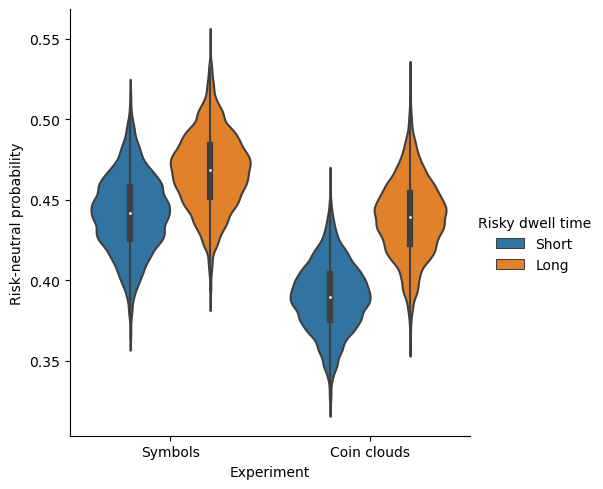

In [8]:
g = sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='Experiment', y='rnp', kind='violin', hue='Risky dwell time', col_order=['Coin clouds', 'Symbols'])

g.set_titles('{col_name}')
g.set(ylabel='Risk-neutral probability')
g.savefig(op.join(target_dir, 'probit_prop_looked_simple_at_rnp.pdf'))

diff
exptype      n_safe       
non-symbolic 5       0.002
             7       0.002
             10      0.002
             14      0.002
             20      0.002
             28      0.002
symbolic     5       0.860
             7       0.860
             10      0.860
             14      0.860
             20      0.860
             28      0.860

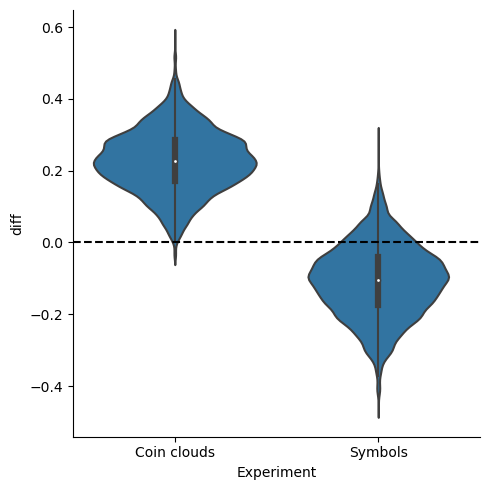

In [26]:
tmp = gamma.stack([1, 2]).droplevel('Risky dwell time').unstack('risky_duration_prop_split').diff(axis=1).iloc[:, -1].to_frame('diff')

g = sns.catplot(x='Experiment', y='diff', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0], order=['Coin clouds', 'Symbols'])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

diff
exptype      n_safe      
non-symbolic 5        1.0
             7        1.0
             10       1.0
             14       1.0
             20       1.0
             28       1.0
symbolic     5        1.0
             7        1.0
             10       1.0
             14       1.0
             20       1.0
             28       1.0

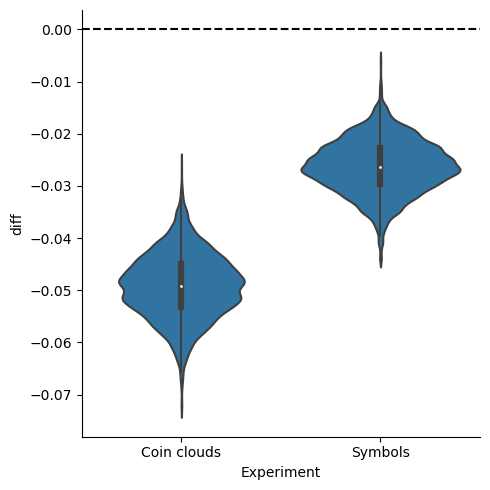

In [27]:
tmp = rnp.stack([1, 2]).droplevel('Risky dwell time').unstack('risky_duration_prop_split').diff(axis=1).iloc[:, -1].to_frame('diff')

g = sns.catplot(x='Experiment', y='diff', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0], order=['Coin clouds', 'Symbols'])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

# Probit proportion looked at risky option (median split)

In [31]:
model_label = 'probit_prop_looked_at_risky_mediansplit'
df, model, idata, gamma, rnp = get_info(model_label)

rnp.set_index(pd.Index(rnp.index.get_level_values('risky_duration_prop_split').to_series().map({'high':'Long', 'low':'Short'}), name='Risky dwell time'), append=True, inplace=True)
gamma.set_index(pd.Index(gamma.index.get_level_values('risky_duration_prop_split').to_series().map({'high':'Long', 'low':'Short'}), name='Risky dwell time'), append=True, inplace=True)

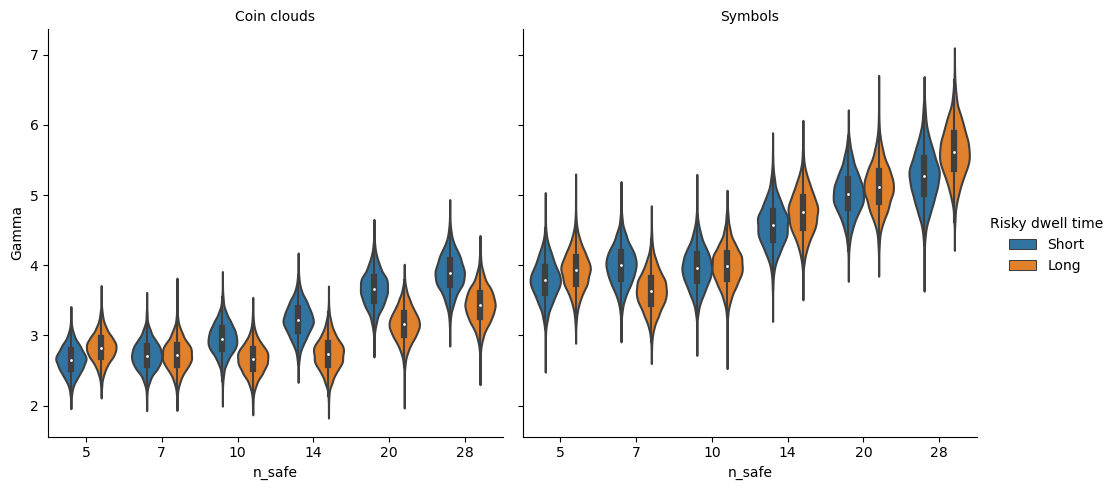

In [4]:
g = sns.catplot(data=gamma.stack([1, 2]).reset_index(), x='n_safe', y='gamma', col='Experiment', kind='violin', hue='Risky dwell time', col_order=['Coin clouds', 'Symbols'])

g.set_titles('{col_name}')
g.set(ylabel='Gamma')
g.savefig(op.join(target_dir, 'probit_prop_looked_at_gamma.pdf'))

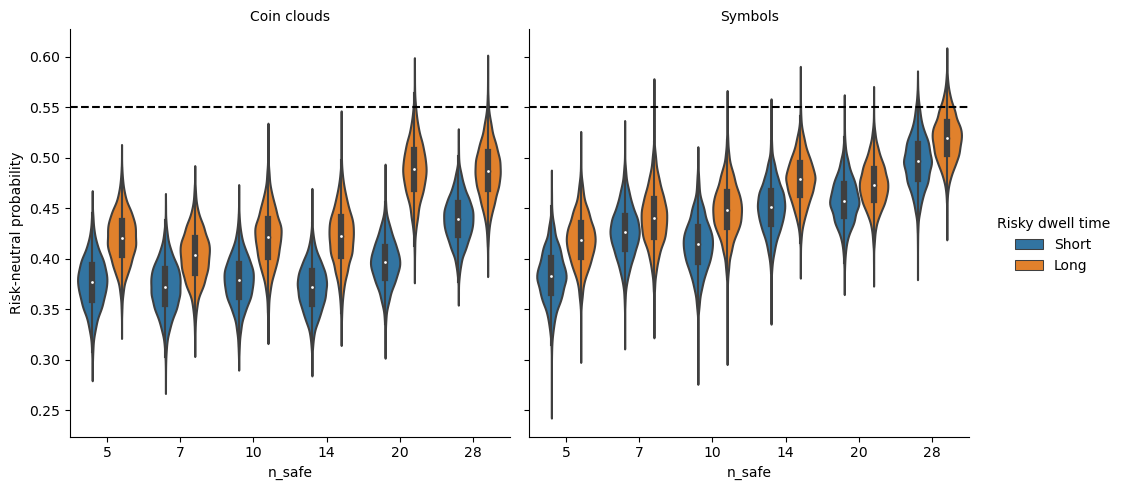

In [35]:
g = sns.catplot(data=rnp.stack([1, 2]).reset_index(), x='n_safe', y='rnp', col='Experiment', kind='violin', hue='Risky dwell time', col_order=['Coin clouds', 'Symbols'])

g.set_titles('{col_name}')
g.set(ylabel='Risk-neutral probability')
g.map(lambda *args, **kwargs: plt.axhline(0.55, c='k' ,ls='--'))

g.savefig(op.join(target_dir, 'probit_prop_looked_at_rnp.pdf'))

In [36]:
tmp = gamma.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs('low', 0, level='risky_duration_prop_split') - tmp.xs('high', 0, level='risky_duration_prop_split')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

ValueError: min() arg is an empty sequence

In [37]:
tmp = rnp.stack([1, 2]).unstack(['exptype', 'n_safe']).droplevel(0, 1)

tmp = tmp.xs('high', 0, level='risky_duration_prop_split') - tmp.xs('low', 0, level='risky_duration_prop_split')
tmp = tmp.stack([0, 1]).to_frame('diff')

g = sns.catplot(x='n_safe', y='diff', col='exptype', data=tmp.reset_index(), kind='violin', color=sns.color_palette()[0])
g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
tmp.groupby(['exptype', 'n_safe']).apply(lambda x: (x<0.0).mean())

ValueError: min() arg is an empty sequence

## Subjectwise

In [39]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [48]:
rnp = np.clip(get_rnp(intercept, gamma),0, 1)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [52]:
rnp

rnp  \
chain                                                                                         0   
draw                                                                                        0     
subject n_safe exptype      risky_duration_prop_split risky_duration_prop Experiment              
01      14     symbolic     low                       0.0                 Symbols      0.539087   
                            high                      0.0                 Symbols      0.581931   
               non-symbolic low                       0.0                 Coin clouds  0.378554   
                            high                      0.0                 Coin clouds  0.432488   
        5      symbolic     low                       0.0                 Symbols      0.497493   
...                                                                                         ...   
64      20     non-symbolic high                      0.0                 Coin clouds  0.172219   
        7      symbolic     low                       0.0                 Symbols      0.264814   
                            high                      0.0                 Symbols      0.206602   
               non-symbolic low                       0.0                 Coin clouds  0.219379   
                            high                      0.0                 Coin clouds  0.147377   

                                                                                                 \
chain                                                                                             
draw                                                                                        1     
subject n_safe exptype      risky_duration_prop_split risky_duration_prop Experiment              
01      14     symbolic     low                       0.0                 Symbols      0.569399   
                            high                      0.0                 Symbols      0.567225   
               non-symbolic low                       0.0                 Coin clouds  0.441512   
                            high                      0.0                 Coin clouds  0.467257   
        5      symbolic     low                       0.0                 Symbols      0.563647   
...                                                                                         ...   
64      20     non-symbolic high                      0.0                 Coin clouds  0.205883   
        7      symbolic     low                       0.0                 Symbols      0.224728   
                            high                      0.0                 Symbols      0.271512   
               non-symbolic low                       0.0                 Coin clouds  0.114217   
                            high                      0.0                 Coin clouds  0.132126   

                                                                                                 \
chain                                                                                             
draw                                                                                        2     
subject n_safe exptype      risky_duration_prop_split risky_duration_prop Experiment              
01      14     symbolic     low                       0.0                 Symbols      0.600443   
                            high                      0.0                 Symbols      0.599048   
               non-symbolic low                       0.0                 Coin clouds  0.432703   
                            high                      0.0                 Coin clouds  0.463353   
        5      symbolic     low                       0.0                 Symbols      0.563860   
...                                                                                         ...   
64      20     non-symbolic high                      0.0                 Coin clouds  0.290912   
        7      symbolic     low

In [63]:
rnp_ = rnp.groupby(['subject', 'risky_duration_prop_split', 'Experiment', 'n_safe']).mean().mean(1).to_frame('rnp')

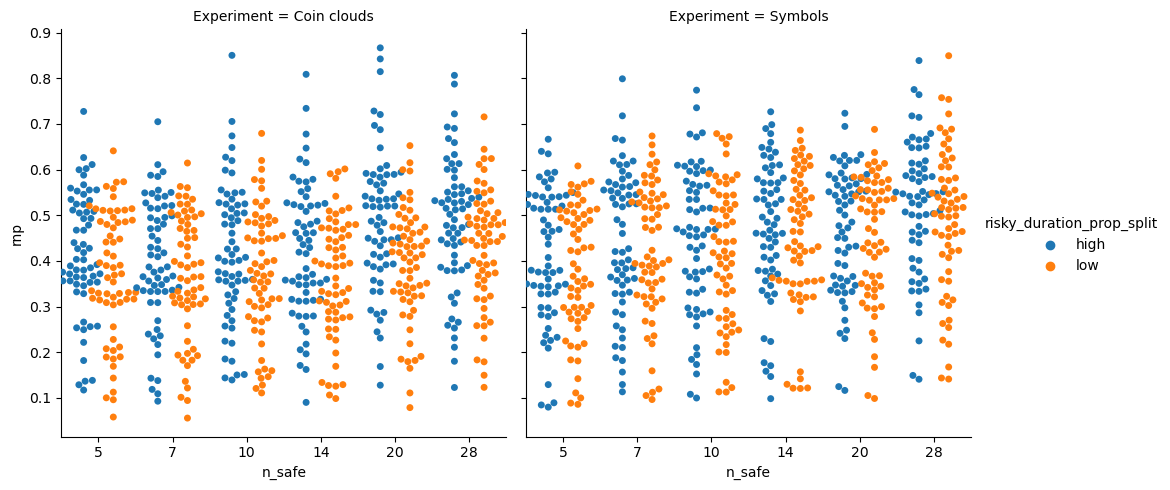

In [64]:
sns.catplot(x='n_safe', y='rnp', hue='risky_duration_prop_split', col='Experiment', data=rnp_.reset_index(), kind='swarm', dodge=True)

In [65]:
import statsmodels.api as sm
def get_rnp_slope(d):
    return sm.OLS(d['rnp'], sm.add_constant(d.index.get_level_values('n_safe'))).fit().params['x1']

In [ ]:
rnp_.groupby(['subject', 'Experiment', ''])

In [66]:
get_rnp_slope(rnp_)

0.0036513606167159485

# Probit proportion looked at risky option (simple)

In [44]:
model_label = 'probit_prop_looked_at_risky_simple'
df, model, idata, gamma, rnp = get_info(model_label)

OSError: [Errno -51] NetCDF: Unknown file format: b'/data/ds-riskeye/derivatives/cogmodels/model-probit_prop_looked_at_risky_simple_trace.netcdf'

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_85516/3025811428.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['risky_duration_prop'].to_dataframe())
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_85516/3025811428.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: ylabel='Density'>

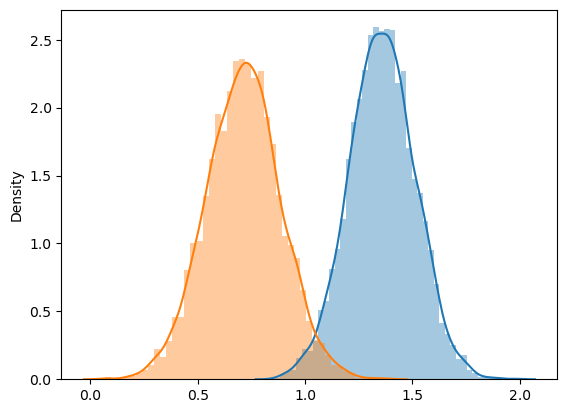

In [ ]:
sns.distplot(idata.posterior['risky_duration_prop'].to_dataframe())
sns.distplot(idata.posterior['risky_duration_prop'].to_dataframe() + idata.posterior['risky_duration_prop:exptype'].to_dataframe().values)

In [57]:
sns.distplot(idata.posterior['x:risky_duration_prop'].to_dataframe())
sns.distplot(idata.posterior['x:risky_duration_prop'].to_dataframe() + idata.posterior['x:risky_duration_prop:exptype'].to_dataframe().values)

KeyError: 'x:risky_duration_prop'